# Job titles modeling
Notebook to group job descriptions into topics, which then can be used in prediction model and future eda analysis. Spacy was used for tokenization and lemmatization, and LDA algorithm from gensim for topic modeling. Data is firstly preprocessed, then vectorized and finally LDA model is trained. The model is then evaluated and saved for future use. Preprocessing pipeline is saved as well.

In [1]:
import pandas as pd

jobs_df = pd.read_csv('data/LinkedInJobs_MLDataset.csv')
jobs_df.head()

,Co_Nm,Co_Pg_Lstd,Emp_Cnt,Flw_Cnt,Job_Ttl,Job_Desc,Is_Supvsr,max_sal,med_sal,min_sal,...,st_code,is_remote,views,app_typ,app_is_off,xp_lvl,domain,has_post_domain,is_sponsored,base_comp
0,HearingLife,True,1171,11417,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,False,5250.00,5250.00,5250.00,...,SC,0,9,OffsiteApply,True,Entry level,careers-demant.icims.com,True,0,1
1,"Metalcraft of Mayville, Inc.",True,300,2923,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,False,0.00,0.00,0.00,...,WI,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,True,0,0
2,"U.S. Tsubaki Power Transmission, LLC",True,314,8487,"Manager, Engineering",The TSUBAKI name is synonymous with excellence...,True,0.00,0.00,0.00,...,AL,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,True,0,0
3,Episcopal Communities & Services,True,36,305,Cook,descriptionTitle\n\n Looking for a great oppor...,False,22.27,22.27,22.27,...,CA,0,1,OffsiteApply,True,Entry level,jobs.apploi.com,True,0,1
4,"iHerb, LLC",True,1227,51933,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",False,275834.00,240895.00,205956.00,...,XF,1,0,OffsiteApply,True,Mid-Senior level,careers.iherb.com,True,0,1


In [2]:
import spacy
import re
from tqdm import tqdm

def nlp_preprocessing(texts):
    nlp = spacy.load('en_core_web_sm')
    texts = [re.sub(r'[\d?,.;:!/-]', '', x).strip().lower() for x in texts]
    texts = list(tqdm(nlp.pipe(texts, n_process=10), total=len(texts)))

    return texts

jobs_df['Job_Desc'] = jobs_df['Job_Desc'].astype('str')
texts = nlp_preprocessing(jobs_df.Job_Desc.values)

100%|██████████| 33246/33246 [04:29<00:00, 123.14it/s]


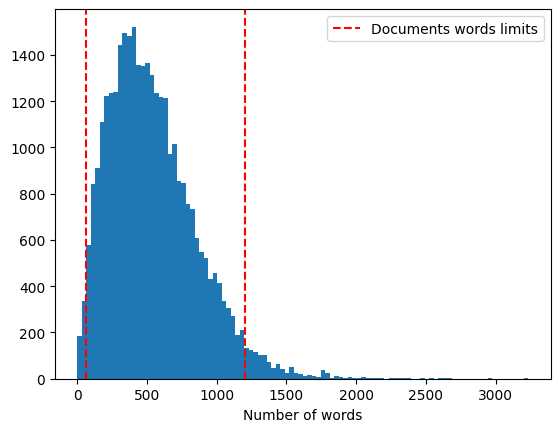

In [3]:
import matplotlib.pyplot as plt
from itertools import compress

min_words_limit = 60
max_words_limit = 1200
plt.hist([len(x) for x in texts], bins=100)
plt.axvline(min_words_limit, linestyle='dashed', c='r', label='Documents words limits')
plt.axvline(max_words_limit, linestyle='dashed', c='r')
plt.xlabel('Number of words')
plt.legend()
plt.show()

def cut_short(texts, min, max):
    is_in_words_limit = [len(x) > min and len(x) < max for x in texts]
    texts = list(compress(texts, is_in_words_limit))
    return texts

texts = cut_short(texts, min_words_limit, max_words_limit)

In [4]:
from gensim.corpora import Dictionary
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(texts):
    stop_words = list("\n firm type diploma closing date send level space job offer company firms oct connect jobs \
                    fcfa price spaces articles tax year cv job interview motivation letter advice questions mail \
                    work answers recruiters expired internship company send do activity sector have profile file \
                    company years address direction cv location benefit healthcare knowledge pet week gender status \
                    disability orientation color experience team include require skill ™ opportunity ability need ensure \
                    use care base pay position include requirement responsibility degree qualification member qualification \
                    apply application office candidate day make provide policy life applicant value part practice hour range \
                    area assign join relate change follow standard salary prefer function career regard field take age identity \
                    problem project service religion receive state tool description â€œhand".split())
    stop_words += list(STOP_WORDS)
    stop_words = set(stop_words)

    texts = [[word.lemma_ for word in doc if (word.pos_ in ['NOUN', 'VERB']) and (word.lemma_ not in stop_words)] for doc in tqdm(texts)]
    return texts

texts = remove_stopwords(texts)

100%|██████████| 31675/31675 [00:07<00:00, 4054.56it/s]


100%|██████████| 31675/31675 [00:00<00:00, 42319.32it/s]


Words count:  182235
Min word document popularity limit:  0.00041041831097079714


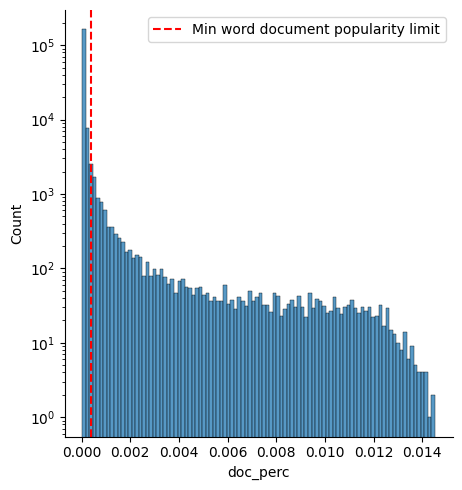

In [5]:
import seaborn as sns
import numpy as np

n_words_to_keep = 10000

def create_words_popularity_df(texts):
    words_popularity_df = pd.DataFrame.from_records([{'id': i, 'word': word} for doc in texts for i, word in enumerate(doc)])
    words_popularity_df = words_popularity_df.drop_duplicates(subset=['id', 'word'])
    words_popularity_df = words_popularity_df.groupby(['word']).count().sort_values(by='id', ascending=False)
    words_popularity_df['doc_perc'] = words_popularity_df['id'] / len(texts)

    return words_popularity_df

def keep_n_popular_words(texts, words_popularity_df, n_words_to_keep):
    words_to_keep = set(words_popularity_df[:n_words_to_keep].index.values)
    texts = [[word for word in doc if word in words_to_keep] for doc in tqdm(texts)]
    return texts

words_popularity_df = create_words_popularity_df(texts)
texts = keep_n_popular_words(texts, words_popularity_df, n_words_to_keep)

min_doc_perc_limit = words_popularity_df['doc_perc'].quantile(1 - n_words_to_keep/len(words_popularity_df))
print('Words count: ', len(words_popularity_df))
print('Min word document popularity limit: ', min_doc_perc_limit)
sns.displot(words_popularity_df, x='doc_perc', bins=100)
plt.axvline(min_doc_perc_limit, linestyle='dashed', c='r', label='Min word document popularity limit')
plt.yscale('log')
plt.legend()
plt.show()

In [6]:
def create_corpus(texts):
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    return corpus, dictionary

corpus, dictionary = create_corpus(texts)

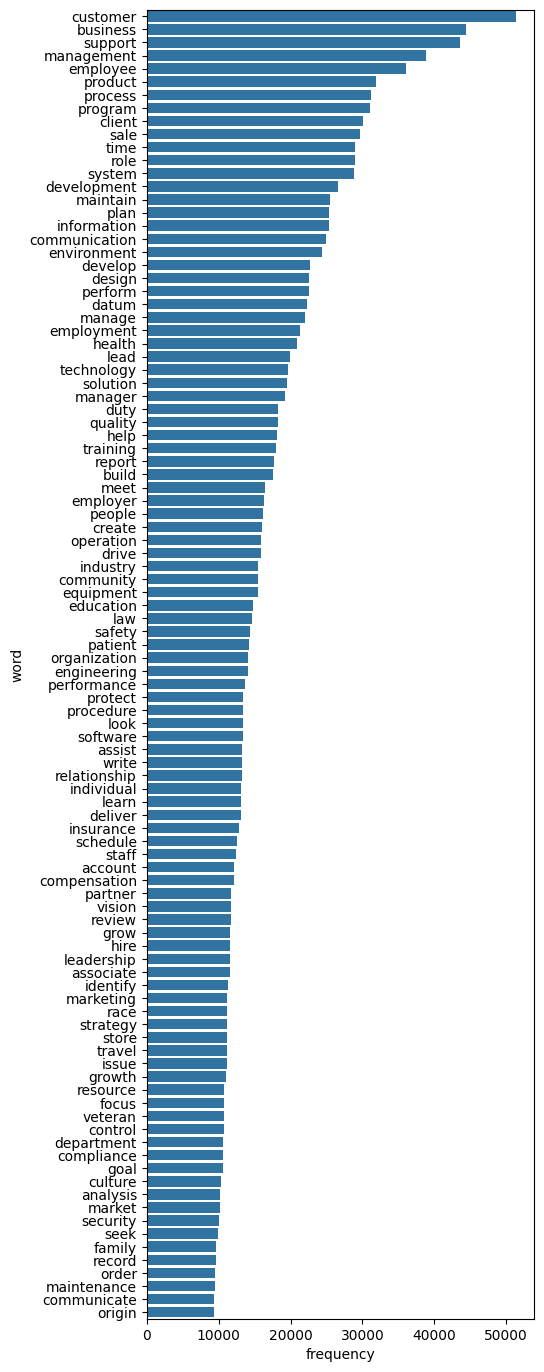

In [7]:
import pandas as pd

bag_of_words_df = pd.DataFrame.from_records([{'word': dictionary[id], 'frequency': freq, 'id': i} for doc in corpus for i, (id, freq) in enumerate(doc)])
bag_of_words_df = bag_of_words_df.groupby('word').sum().sort_values('frequency', ascending=False)
bag_of_words_df.reset_index(inplace=True)

plt.figure(figsize=(5, 17))
sns.barplot(x='frequency', y='word', data=bag_of_words_df.head(100))
plt.show()

100%|██████████| 8/8 [02:12<00:00, 16.55s/it]


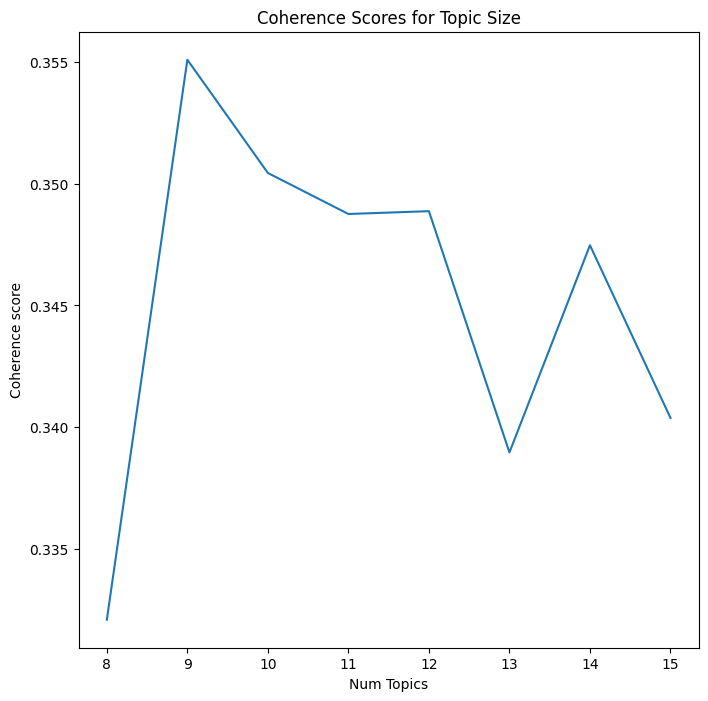

In [8]:
import matplotlib.pyplot as plt

from gensim.models import LdaMulticore, CoherenceModel

def compute_lda(corpus, dictionary, texts, num_topics):
    coherence_values = []
    model_list = []
    
    for num_topics in tqdm(num_topics):
        lda_model = LdaMulticore(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics, 
                                random_state=123,
                                chunksize=100,
                                per_word_topics=True)
        model_list.append(lda_model)
        
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values
    
start=8; end=16; step=1
num_topics = list(range(start, end, step))
model_list, coherence_values = compute_lda(corpus, dictionary, texts, num_topics)

# Show graph
x = range(start, end, step)
ax = plt.subplots(figsize=(8,8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Coherence Scores for Topic Size')
plt.show()

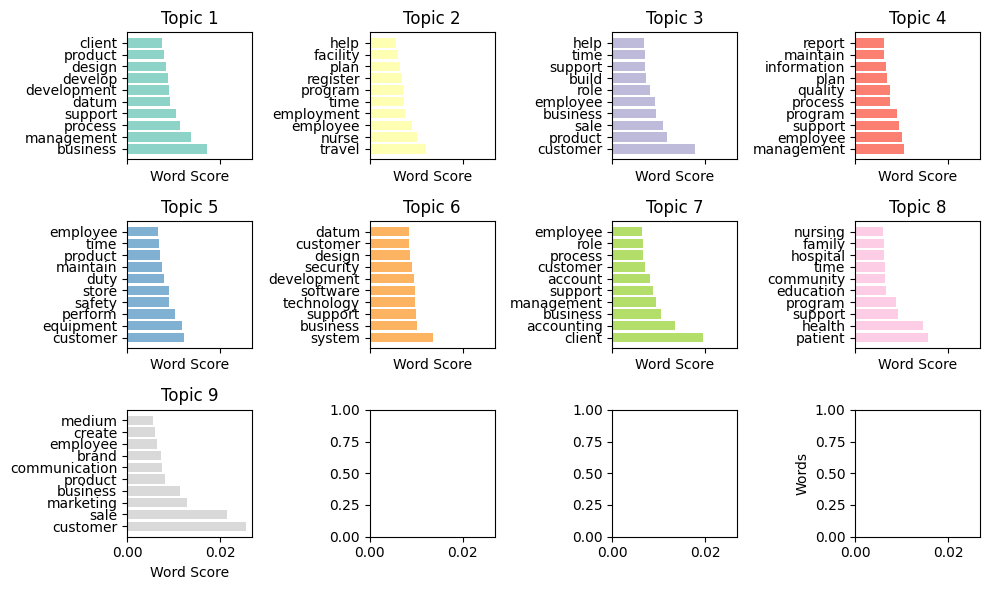

In [26]:
import math

def plot_topic_words(model, num_words):
    num_columns = 4
    num_rows = math.ceil(model.num_topics / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 2*num_rows), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < model.num_topics:
            topic_words = model.show_topic(i, num_words)
            words = [word for word, _ in topic_words]
            word_scores = [score for _, score in topic_words]
            
            ax.barh(words, word_scores, color=plt.cm.Set3(i))
            ax.set_title(f'Topic {i+1}')
            ax.set_xlabel('Word Score')

    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

plot_topic_words(best_model, num_words=10)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

coherence_values = np.array(coherence_values)
best_model_index = coherence_values.argmax()
best_model = model_list[best_model_index]
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)

In [10]:
import joblib

def preprocess_lda_pipeline(df):
    df['Job_Desc'] = df['Job_Desc'].astype('str')
    texts = nlp_preprocessing(df.Job_Desc.values)
    texts = remove_stopwords(texts)
    words_popularity_df = create_words_popularity_df(texts)
    texts = keep_n_popular_words(texts, words_popularity_df, n_words_to_keep)
    corpus, dictionary = create_corpus(texts)
    
    return corpus, dictionary, texts

best_model.save('models/job_topic_lda_best_model.model')
joblib.dump(preprocess_lda_pipeline, 'models/preprocess_lda_pipeline.joblib')

['models/preprocess_lda_pipeline.joblib']